# Topological Data Analysis (TDA)

TDA for detecting changes in time series.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

## Get raw data

In [2]:
df1 = pd.read_csv("../data/kaer_insead_at_8May18-21786.csv",
                  index_col="Time Stamp",
                  parse_dates=True)

df2 = pd.read_csv("../data/kaer_insead_at_8May18-27169.csv",
                  index_col="Time Stamp",
                  parse_dates=True)

df1.index.name = "timestamp"
df2.index.name = "timestamp"

display_side_by_side(df1.head(), df2.head())

/home/hongwei2/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr
timestamp,,,,,,,,,
2016-02-01 00:00:00,0.00000,30.4664,0,0,0,0,0,0,0
2016-02-01 00:01:00,8.46289,30.3218,27.143,536.522,0.844,0.856,82.944,113.924,407.278
2016-02-01 00:02:00,8.50649,30.2704,27.1343,531.157,0.848,0.88,81.92,111.232,402.875
2016-02-01 00:03:00,8.52001,30.2337,27.1465,532.766,0.864,0.868,80.896,108.164,395.83
2016-02-01 00:04:00,8.48630,30.2245,27.151,534.376,0.872,0.88,79.872,105.685,385.703
,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr
timestamp,,,,,,,,,
2018-04-01 00:00:00,0.0000,0.0000,0.0000,576.223,42.24,0.848,0,95.6832,486.972
2018-04-01 00:01:00,10.7674,28.8237,26.3996,579.979,42.24,0.852,0,96.2943,486.091


In [3]:
df1 = df1.replace("\\N", np.nan)
df2 = df2.replace("\\N", np.nan)

## Analyze missing values

In [ ]:
# Group data by day of month and count number of entries that are null
# Display only days with missing entries
missing1 = df1.isnull().groupby(df1.index.to_period("D")).sum()
missing1.loc[np.any(missing1 > 0, axis=1)]

In [ ]:
# Group data by day of month and count number of entries that are null
# Display only days with missing entries
missing2 = df2.isnull().groupby(df2.index.to_period("D")).sum()
missing2.loc[np.any(missing2 > 0, axis=1)]

In [ ]:
df1_null = df1.isnull().sum().to_frame("Number of '\\N' entries")
df2_null = df2.isnull().sum().to_frame("Number of '\\N' entries")
display_side_by_side(df1_null, df2_null)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

(df1.isnull().astype(int)).plot(ax=axes[0])
(df2.isnull().astype(int)).plot(ax=axes[1])

fig.suptitle("Missing values in dataset")
axes[0].set_title("Year 2016")
axes[1].set_title("Year 2018");

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

(df1.isnull().astype(int)).groupby(df1.index.to_period("D")).sum().plot(ax=axes[0])
(df2.isnull().astype(int)).groupby(df2.index.to_period("D")).sum().plot(ax=axes[1])

fig.suptitle("Missing values in dataset")
axes[0].set_title("Year 2016")
axes[1].set_title("Year 2018");

## Convert data type to float

In [4]:
def fix_dtypes(df, columns):
    for c in columns:
        if df.dtypes[c] != np.float64:
            df[c] = pd.to_numeric(df[c], errors="raise")
    return df

In [5]:
col_names = ['chwshdr', 'cwrhdr', 'cwshdr', 'cwsfhdr', 
             'ch1kw', 'ch2kw', 'ch3kw','loadsys', 'chwsfhdr']

df1 = fix_dtypes(df1, col_names)
df2 = fix_dtypes(df2, col_names)
df1.dtypes, df2.dtypes

(chwshdr     float64
 cwrhdr      float64
 cwshdr      float64
 cwsfhdr     float64
 ch1kw       float64
 ch2kw       float64
 ch3kw       float64
 loadsys     float64
 chwsfhdr    float64
 dtype: object, chwshdr     float64
 cwrhdr      float64
 cwshdr      float64
 cwsfhdr     float64
 ch1kw       float64
 ch2kw       float64
 ch3kw       float64
 loadsys     float64
 chwsfhdr    float64
 dtype: object)

## Resample time-series

In [7]:
df1_sampled = df1.groupby(pd.Grouper(freq='D')).resample("5min", closed="left", label="right").mean()
df1_sampled.reset_index(level=0, inplace=True)
df2_sampled = df2.groupby(pd.Grouper(freq='D')).resample("5min", closed="left", label="right").mean()
df2_sampled.reset_index(level=0, inplace=True)
display_side_by_side(df1_sampled.head(3), df2_sampled.head(3))

,timestamp,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr
timestamp,,,,,,,,,,
2016-02-01 00:05:00,2016-02-01,6.795138,30.30336,21.71496,426.9642,0.6856,0.6968,65.1264,87.80100,318.3372
2016-02-01 00:10:00,2016-02-01,8.469926,30.04602,27.10646,524.1820,0.8672,0.8720,75.5712,101.22132,371.9654
2016-02-01 00:15:00,2016-02-01,8.450484,29.83354,27.04058,512.3792,0.8720,0.8688,69.5296,89.08462,354.9698
,timestamp,chwshdr,cwrhdr,cwshdr,cwsfhdr,ch1kw,ch2kw,ch3kw,loadsys,chwsfhdr
timestamp,,,,,,,,,,
2018-04-01 00:05:00,2018-04-01,8.61446,23.05286,21.11866,580.4080,42.2400,0.8504,0.0,95.41384,485.4748
2018-04-01 00:10:00,2018-04-01,10.71612,28.72886,26.38856,578.7986,41.1136,0.8472,0.0,89.89642,483.0092
2018-04-01 00:15:00,2018-04-01,10.70414,28.54420,26.33778,579.4422,39.8848,0.8488,0.0,86.63760,478.6938


## Create binary on/off state of chillers

In [8]:
def assign_chiller_state(df, threshold):
    df = df.assign(ch1_status=(df.ch1kw >= threshold).astype(np.int))
    df = df.assign(ch2_status=(df.ch2kw >= threshold).astype(np.int))
    df = df.assign(ch3_status=(df.ch3kw >= threshold).astype(np.int))
    return df

In [9]:
threshold = 10
df1_sampled = assign_chiller_state(df1_sampled, threshold)
df2_sampled = assign_chiller_state(df2_sampled, threshold)

## Create target value

$$\text{totalkw} = \sum_{i = 1}^3 \text{ch<i>kw}$$

In [10]:
outputs = ["ch1kw", "ch2kw", "ch3kw"]
df1_sampled = df1_sampled.assign(totalkw=df1_sampled.loc[:, outputs].sum(axis=1))
df2_sampled = df2_sampled.assign(totalkw=df2_sampled.loc[:, outputs].sum(axis=1))

## Visualize difference between original and re-sampled

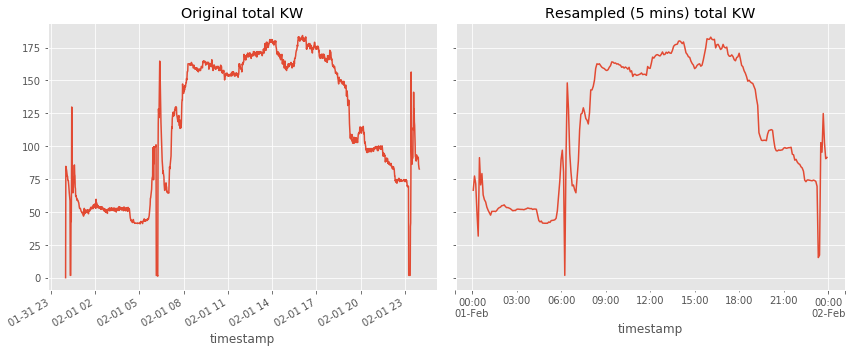

In [13]:
# Visualize one example
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

df1.loc["2016-02-01", outputs].sum(axis=1).plot(ax=axes[0], title="Original total KW")
df1_sampled.loc["2016-02-01"].totalkw.plot(ax=axes[1], title="Resampled (5 mins) total KW")

fig.tight_layout()

## Save processed data

In [17]:
df1_raw = df1
df2_raw = df2

df1 = df1_sampled
df2 = df2_sampled

df1_raw.to_csv("../data/insead_2016.csv")
df2_raw.to_csv("../data/insead_2018.csv")

df1.to_csv("../data/insead_2016_resampled.csv")
df2.to_csv("../data/insead_2018_resampled.csv")

## Read processed data

In [ ]:
df1_raw = pd.read_csv("../data/insead_2016.csv", index_col="timestamp", parse_dates=["timestamp"])
df2_raw = pd.read_csv("../data/insead_2018.csv", index_col="timestamp", parse_dates=["timestamp"])

df1 = pd.read_csv("../data/insead_2016_resampled.csv", index_col="timestamp", parse_dates=["timestamp"])
df2 = pd.read_csv("../data/insead_2018_resampled.csv", index_col="timestamp", parse_dates=["timestamp"])

## Final set of attributes

In [18]:
pd.DataFrame(df1.columns, columns=["Attribute"])

,Attribute
0,timestamp
1,chwshdr
2,cwrhdr
3,cwshdr
4,cwsfhdr
5,ch1kw
6,ch2kw
7,ch3kw
8,loadsys
9,chwsfhdr


## Features and target

In [20]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 

"ch1_status",
"ch2_status",
"ch3_status",
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw",
          # "ch1kw",
          # "ch2kw",
          # "ch3kw",    
         ]

## Plot time series

In [22]:
def plot_days(df, features, ndays, ncols=2, offset=0, title=None, figsize=None):
    
    grouper = df.loc[:, features].groupby([df.index.year, 
                                           df.index.month,
                                           df.index.day])
    
    nrows = int(ndays / ncols + 0.5)
    
    if figsize is None:
        figsize = (ncols * 6, nrows * 2)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
    for i, key in enumerate(grouper.groups.keys()):
        if i == ndays:
            break
            
        r = i // ncols
        c = i % ncols
        ax = axes[r, c]
        g = grouper.get_group(key)
        g.plot(ax=ax, legend=False)
        ax.set_title(g.index[0].weekday_name)
        ax.set_xlabel("")

    if title is not None:
        fig.suptitle(title, fontsize=20)
        
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5),
               fancybox=True, shadow=True, ncol=1)
    
    fig.text(0.5, 0.01, 'Time Stamp', ha='center', fontsize=20)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    

def plot_weeks(df, features, nweeks, ncols=2, offset=0, title=None, figsize=None):
    grouper = df.loc[:, features].groupby([df.index.week])
    
    nrows = int(nweeks / ncols + 0.5)
    
    if figsize is None:
        figsize = (ncols * 6, nrows * 2)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=True)
    for i, key in enumerate(grouper.groups.keys()):
        if i == nweeks:
            break
            
        r = i // ncols
        c = i % ncols
        ax = axes[r, c]
        g = grouper.get_group(key)
        g.plot(ax=ax, legend=False)
        ax.set_title("Week {} of year".format(g.index[0].week))
        ax.set_xlabel("")

    if title is not None:
        fig.suptitle(title, fontsize=20)
        
    lines = ax.get_lines()
    labels = [l.get_label() for l in lines]
    fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5),
               fancybox=True, shadow=True, ncol=1)

    fig.text(0.5, 0.01, 'Time Stamp', ha='center', fontsize=20)
#     fig.text(0.04, 0.5, '', va='center', rotation='vertical')    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])    

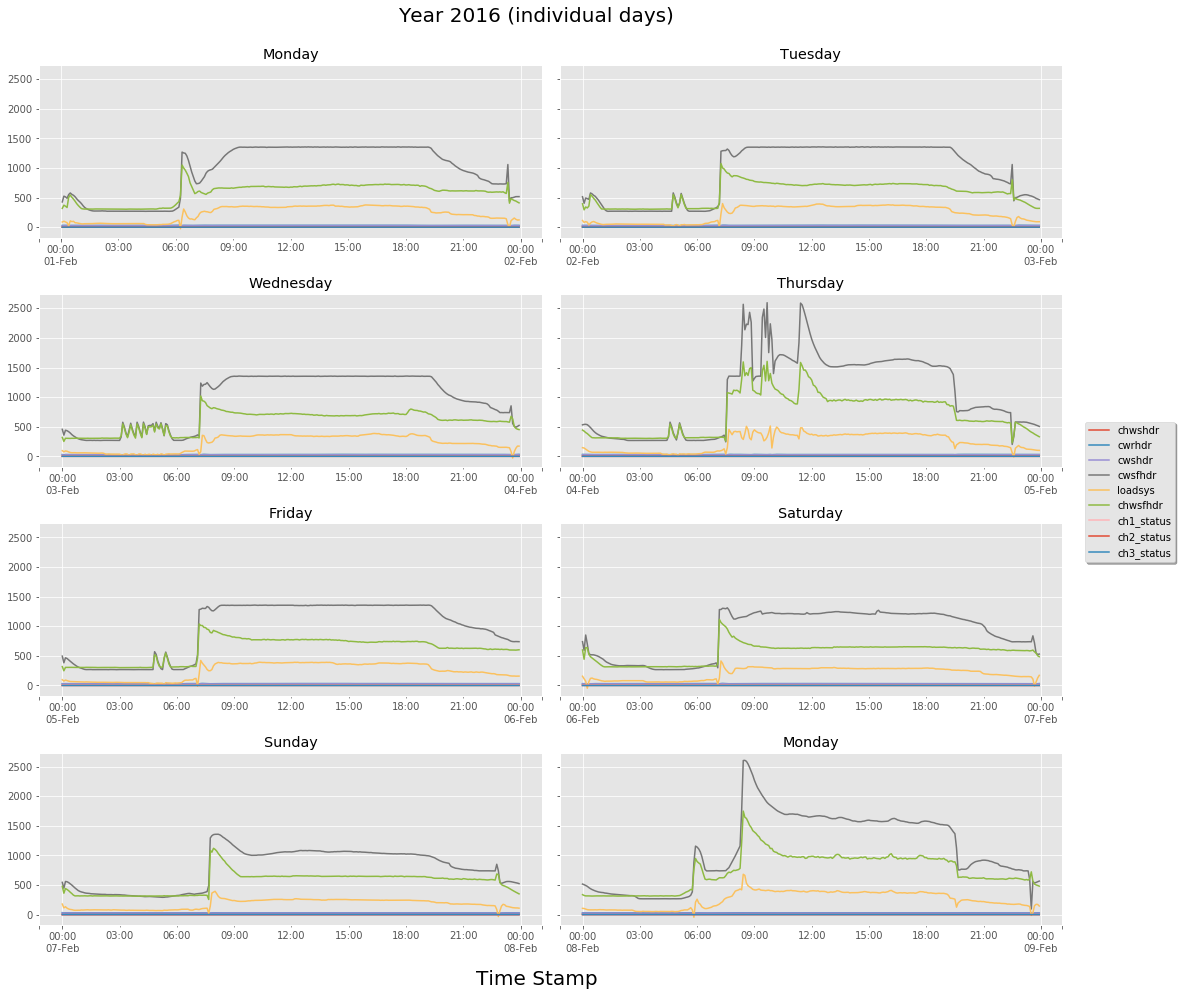

In [23]:
plot_days(df1, features, ndays=8, title="Year 2016 (individual days)", 
          figsize=(15, 14))

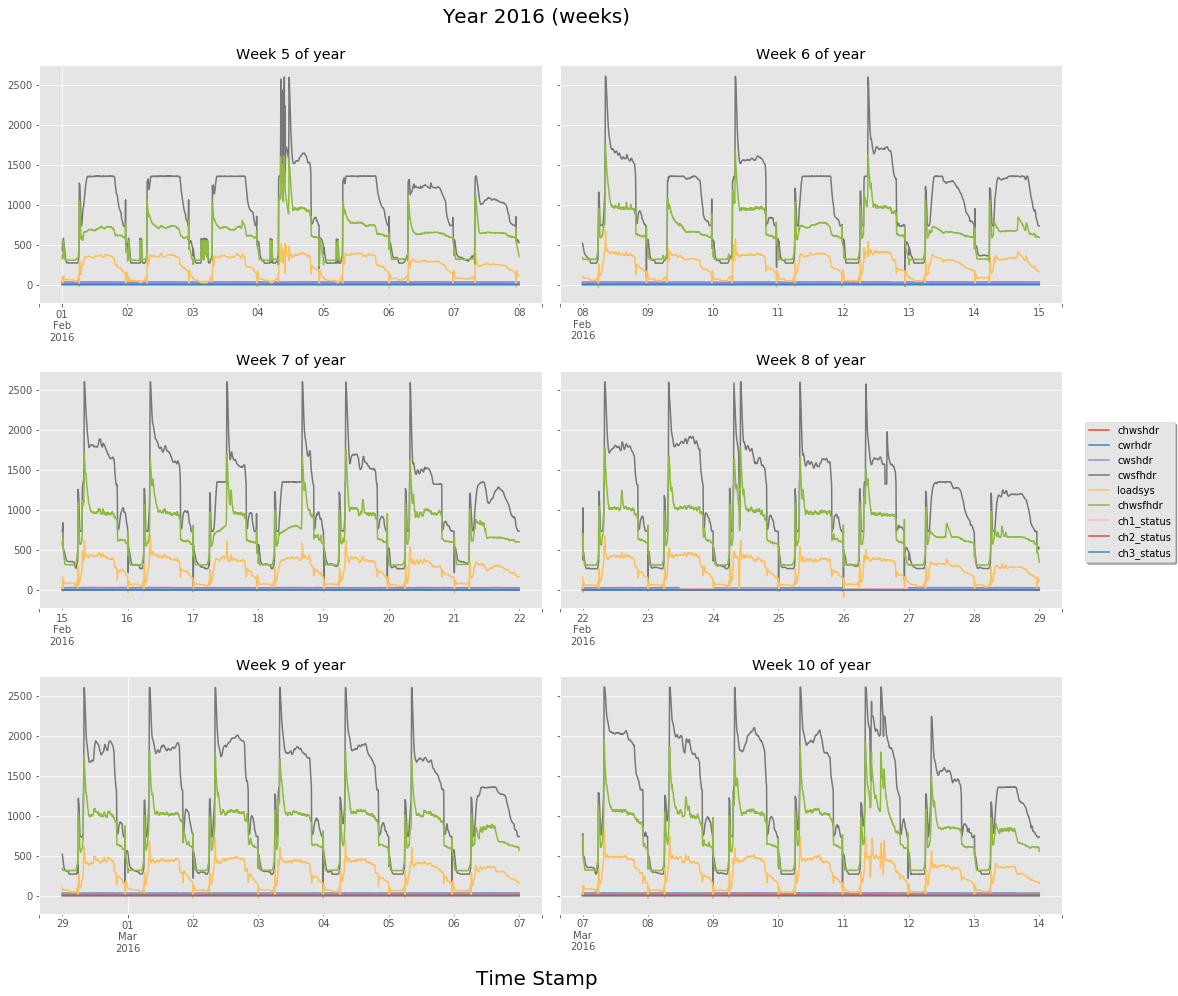

In [24]:
plot_weeks(df1, features, nweeks=6, 
          title="Year 2016 (weeks)", 
          figsize=(15, 14))

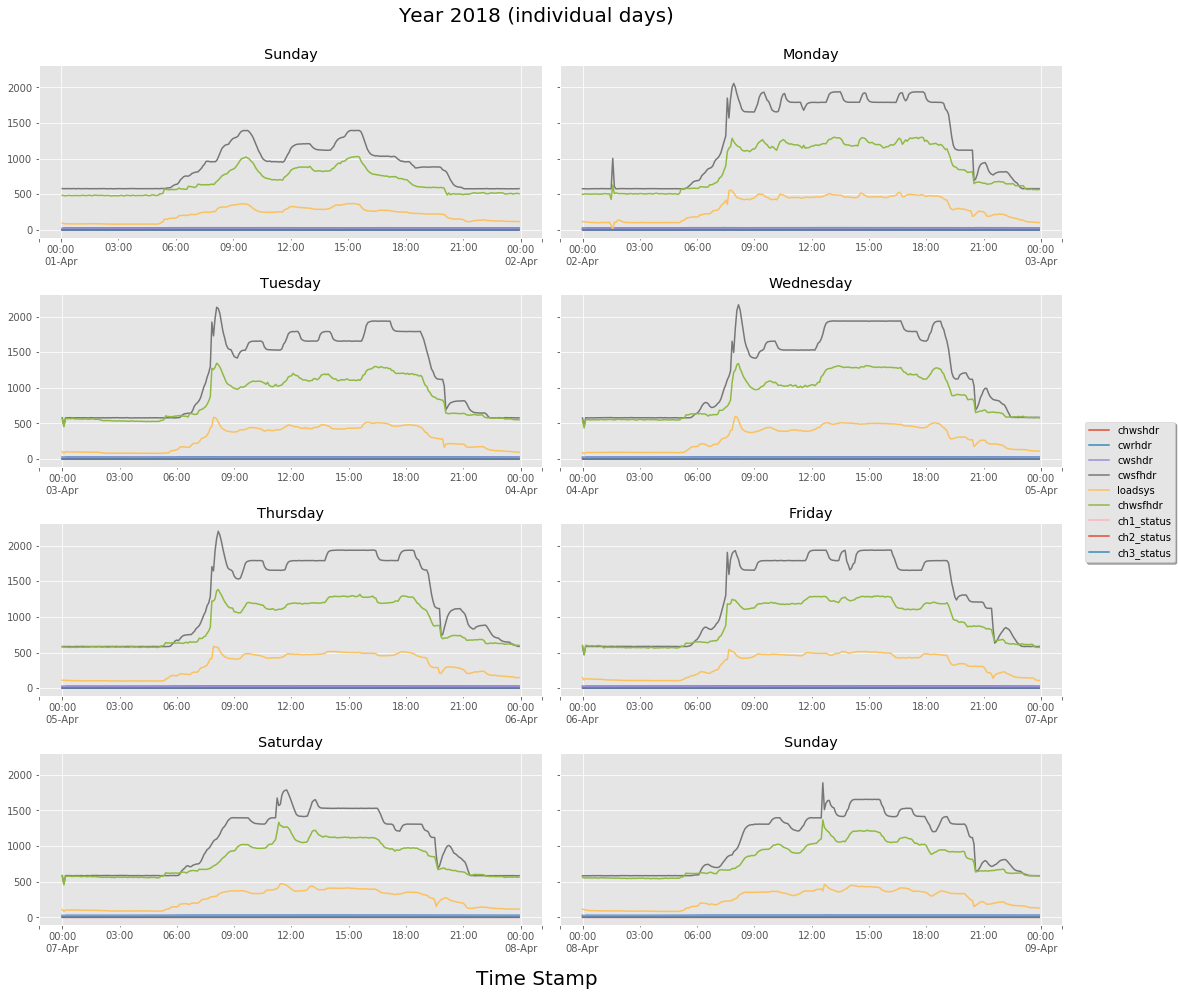

In [25]:
plot_days(df2, features, ndays=8, title="Year 2018 (individual days)", 
          figsize=(15, 14))

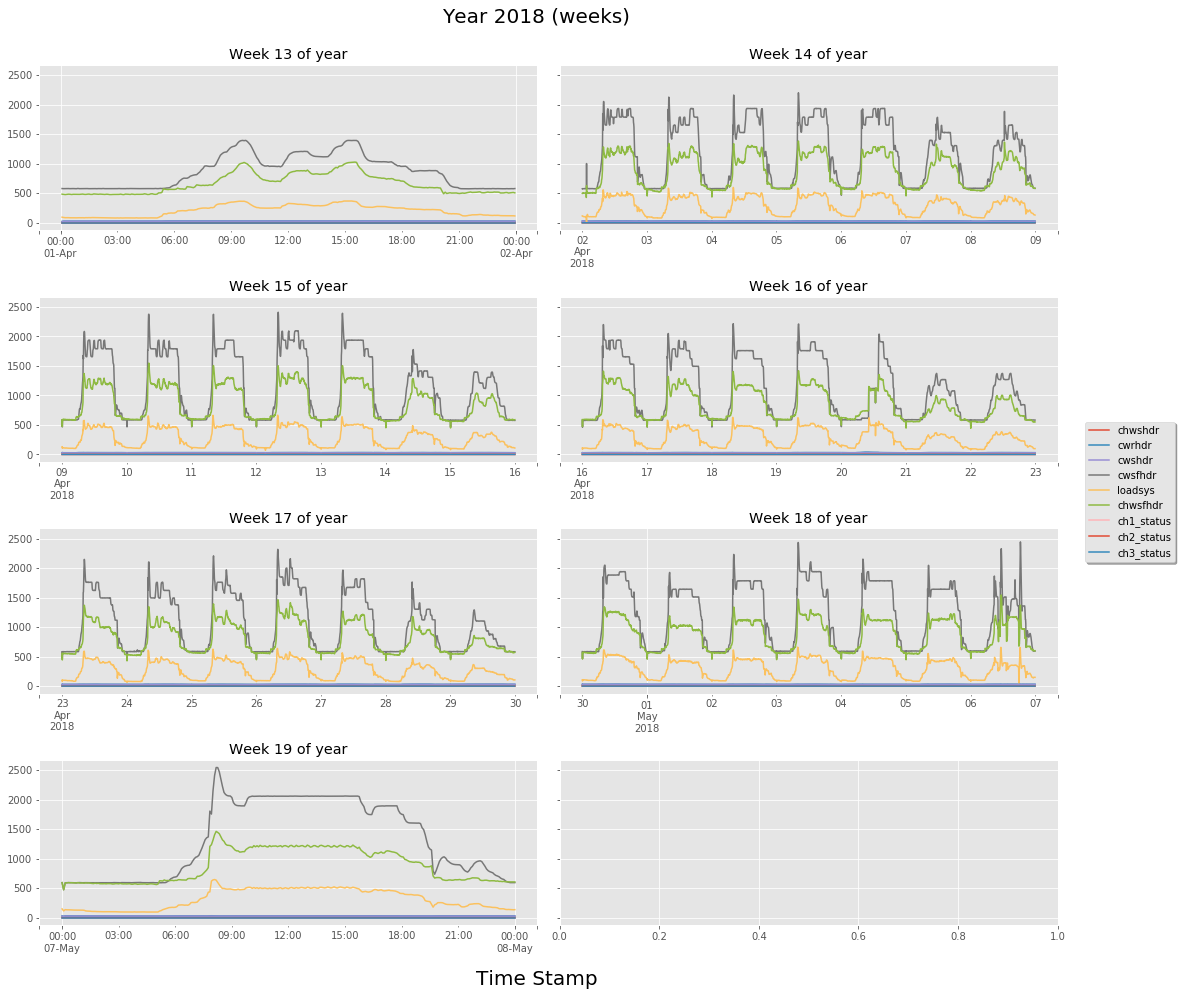

In [26]:
plot_weeks(df2, features, nweeks=7, 
          title="Year 2018 (weeks)", 
          figsize=(15, 14))

---

## Sliding window embeddings

Extract sliding window delayed embeddings from time series for each week.

Can also consider using HMM to model sequence and encode sequence using Fisher vector approach.

In [27]:
def sliding_win_embeddings(x, dim, Tau, dT):
    """
    Taken from https://github.com/lightalchemist/TUMTopoTimeSeries2016/blob/master/1-SlidingWindowBasics.ipynb
    """
    import scipy.interpolate as interp
    
    N = len(x)
    NWindows = int(np.floor((N - dim * Tau) / dT))  #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    
    X = np.zeros((NWindows,
                  dim))  #Create a 2D array which will store all windows
    idx = np.arange(N)
    
    order = []
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = dT * i + Tau * np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1])) + 2
        if end >= len(x):
            X = X[0:i, :]
            break
        #Do spline interpolation to fill in this window, and place
        #it in the resulting array
        X[i, :] = interp.spline(idx[start:end + 1], x[start:end + 1], idxx)
        
        # Set order to be time of day
        
        order.append((start + end) / 2)
    
    order = np.asarray(order)
        
    return X, order

In [ ]:
dim = 20
# dim = 10
tau = 1
dT = 0.5

# TODO: Configure period to be a day
# TODO: What are dim, tau, and dT?

# 2016 data
grouper = df1.loc[:, features].groupby([df1.index.week])
keys = list(grouper.groups.keys())

x1 = grouper.get_group(keys[0]).totalkw
x2 = grouper.get_group(keys[3]).totalkw

X1, order_x1 = sliding_win_embeddings(x1, dim, tau, dT)
X2, order_x2 = sliding_win_embeddings(x2, dim, tau, dT)

# 2018 data
grouper = df2.loc[:, features].groupby([df2.index.week])
keys = list(grouper.groups.keys())

# Skip first group which only consists of 1 day
y1 = grouper.get_group(keys[1]).totalkw
y2 = grouper.get_group(keys[4]).totalkw

Y1, order_y1 = sliding_win_embeddings(y1, dim, tau, dT)
Y2, order_y2 = sliding_win_embeddings(y2, dim, tau, dT)

In [ ]:
X1.shape, X2.shape, Y1.shape, Y2.shape

In [ ]:
%store X1
%store X2
%store Y1
%store Y2

## Plot sliding window embeddings

Plot 3D PCA embeddings of sliding window embeddings.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
Y1 = scaler.fit_transform(Y1)
Y2 = scaler.fit_transform(Y2)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

%matplotlib notebook
%matplotlib notebook

pca = PCA(n_components=3)

XX1 = pca.fit_transform(X1)
XX2 = pca.fit_transform(X2)

YY1 = pca.fit_transform(Y1)
YY2 = pca.fit_transform(Y2)

In [ ]:
plt.figure(figsize=(8, 12))
for i, (Y, order, label) in enumerate(zip([XX1, XX2], 
                                   [order_x1, order_x2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(2, 1, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[:, 0], Y[:, 1], Y[:, 2], 
                 marker='.', #alpha=1,
                 c=order, 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2016", fontsize=14)

plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 12))

step = 1
for i, (Y, order, label) in enumerate(zip([YY1, YY2], 
                                   [order_y1, order_y2],
                                   ["Week 1", "Week 2"]
                                  ), 1):
    
    ax = plt.subplot(2, 1, i, projection="3d")    
    
    ax.plot3D(Y[:, 0], Y[:, 1], Y[:, 2], 'white', alpha=0.4)    
    
    ax.scatter3D(Y[::step, 0], Y[::step, 1], Y[::step, 2], 
                 marker='.', # alpha=0.5,
                 c=order[::step], 
                 cmap='magma',
                 label=label
                )
        
    ax.set_aspect('equal', 'datalim')
    ax.set_title(label)


plt.suptitle("Year 2018", fontsize=14)

plt.tight_layout()

## Resample time-series

Use Pandas to re-sample time series to have uniform sampling rate.

In [ ]:
# Before re-sample

%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for i, x in enumerate([x1, x2, y1, y2]):
    r = i // 2
    c = i % 2
    axes[r, c].plot(x, alpha=0.8)
    axes[r, c].xaxis.set_tick_params(rotation=70)
    
fig.tight_layout()

## TDA distance between descriptors

Compute persistent disgrams for sliding window embeddings.

Can compute on raw data or on PCA embeddings.

Consider using Witness complex or Alpha complex (on PCA embeddings).

Reduce number of points (maybe 2 to 3 days or resample time-series).

Consider using R version for TDA.

Tune $\tau, d, \delta_t$ for generating sliding window embeddings.

In [ ]:
%store -r X1
%store -r X2
%store -r Y1
%store -r Y2

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
Y1 = scaler.fit_transform(Y1)
Y2 = scaler.fit_transform(Y2)

Is the following using Sparse Vietoris Rips complex?

In [ ]:
def compute_persistence(X, max_edge_length=0.5, max_dim=1):
    rips_complex = gd.RipsComplex(points=X.tolist(), max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    diag = simplex_tree.persistence()
    return rips_complex, simplex_tree, diag

In [ ]:
max_dim = 1
max_edge_length = 0.5
ripsX1, simplexX1, diagX1 = compute_persistence(X1, max_edge_length, max_dim)

In [ ]:
ripsX2, simplexX2, diagX2 = compute_persistence(X2, max_edge_length, max_dim)

In [ ]:
ripsY1, simplexY1, diagY1 = compute_persistence(Y1, max_edge_length, max_dim)

In [ ]:
ripsY2, simplexY2, diagY2 = compute_persistence(Y2, max_edge_length, max_dim)

In [ ]:
gd.plot_persistence_diagram(diagX1, max_plots=500)

In [ ]:
gd.plot_persistence_diagram(diagX2, max_plots=100)

In [ ]:
plt = gd.plot_persistence_diagram(diagY1, max_plots=500)

In [ ]:
diagX1[:5]

In [ ]:
diagX2[:5]

## Visualize distances between weeks

In [ ]:
del X1, X2, Y1, Y2

In [ ]:
del ripsX1, ripsX2, ripsY1, ripsY2

In [ ]:
del simplexY1, simplexY2

In [ ]:
len(diagX2)

In [ ]:
dim = 1
gd.bottleneck_distance(simplexX1.persistence_intervals_in_dimension(dim),
                       simplexX2.persistence_intervals_in_dimension(dim),
                       0.1)

## Perform statistical tests

In [ ]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [ ]:
import holoviews as hv

# hv.notebook_extension('bokeh', 'matplotlib')

hv.extension('matplotlib')
# hv.extension('bokeh')

---

# Miscellaneous code

Experiment with Plotly 3D interactive visualizations. This is faster than the Bokeh and Matplotlib-based visualizations at the cost of using much more memory as it uses WebGL to render the graphs locally whereas
Bokeh and Matplotlib are rendered on the server.

In [ ]:
import plotly as py
import plotly.graph_objs as go

import ipywidgets as widgets
from scipy import special

py.offline.init_notebook_mode(connected=True)

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [ ]:
import plotly

In [ ]:
def plot_3d_embeddings(*data, rgba=(217, 217, 217, 0.1), size=1, opacity=0.3, ncols=2):
    n_datasets = len(data)
    nrows = int(n_datasets / ncols + 0.5)
    
    traces = []
    rows = []
    cols = []
    for i, X in enumerate(data):
        r = i // ncols + 1
        c = i % ncols + 1
        
        rows.append(r)
        cols.append(c)
        trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                             mode='markers',
                             marker=dict(size=size, 
                                         line=dict(color='rgba({}, {}, {}, {})'.format(*rgba),
                                                   width=0.5),
                                         color="blue",
                                         opacity=opacity))
        traces.append(trace)
    
#     trace1 = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
#                             mode='markers',
#                             marker=dict(
#                                 size=size,
#                                 line=dict(
#                                     color='rgba(217, 217, 217, 0.14)',
#                                     width=0.5
#                                 ),
#                                 opacity=opacity
#                             ))

#     layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
#     fig = go.Figure(data=[trace1], layout=layout)
#     py.offline.iplot(fig, filename='simple-3d-scatter')
    
    specs = []
    for r in range(nrows):
        rspecs = []
        for c in range(ncols):
            rspecs.append({'is_3d': True})
        specs.append(rspecs)
        
    fig = tools.make_subplots(rows=nrows, 
                              cols=ncols, 
                              specs=specs,
                              horizontal_spacing=0.05)
    fig.add_traces(traces, rows, cols)
    margin = {
    "r": 10,
    "t": 25,
    "b": 40,
    "l": 60
    }
    fig.layout = go.Layout(margin=margin, height=600, width=600)
    
#     fig = go.Figure(rows=nrows, cols=ncols, data=traces, layout=layout)
    py.offline.iplot(fig, filename='simple-3d-scatter')

In [ ]:
plot_3d_embeddings(XX1, XX2, YY1, YY2)

---

In [ ]:
grouper = df2.loc[:, features].groupby([df2.index.week])
keys = list(grouper.groups.keys())
g = grouper.get_group(keys[1])

In [ ]:
len(keys)

In [ ]:
td = (g.index.max() - g.index.min())

In [ ]:
td.days

In [ ]:
grouper.get_group(keys[1])

In [ ]:
len(keys)